<a href="https://colab.research.google.com/github/Dkepffl/2022-2-ESAA/blob/main/Assignment/Assignment221003_Unsupervised_Learning_kaggle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **캐글 실습 필사 : Customers clustering: K-Means, DBSCAN and AP**
___
출처 : https://www.kaggle.com/code/datark1/customers-clustering-k-means-dbscan-and-ap/notebook

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### **1. Introduction**
- 군집(Clustering)의 주요 역할은 레이블이 없는 데이터셋의 **natural group**을 찾는 것이다.
- 군집을 활용할 수 있는 분야는 다음과 같다.
  - customers segmentation (for efficient marketing)
  - image segmentation
  - documents clusterisation.
- 군집 알고리즘에는 크게 두 가지가 있는데, 한 가지는 데이터셋을 계속 작은 subset으로 나누는 **Hierarchical algorithm**이고, 다른 한 가지는 주어진 기준에 따라 데이터셋을 여러 개의 subset으로 나누는 **Partitional algorithm**이 있다.

### **2. Reading data**

In [1]:
# import packages

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

In [2]:
# load data
mall_data = pd.read_csv('/content/drive/MyDrive/2022-2 ESAA/Data/Mall_Customers.csv')

print('There are {} rows and {} columns in our dataset.'.format(mall_data.shape[0],mall_data.shape[1]))

There are 200 rows and 5 columns in our dataset.


- 해당 데이터는 200개의 로우와 5개의 컬럼으로 이루어진 데이터이다.
- `sample` 메서드를 이용하여 데이터셋에 있는 데이터들 중 무작위로 10개를 골라 관찰하였다.

In [3]:
mall_data.sample(10)

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
41,42,Male,24,38,92
186,187,Female,54,101,24
34,35,Female,49,33,14
71,72,Female,47,49,42
81,82,Male,38,54,55
43,44,Female,31,39,61
16,17,Female,35,21,35
182,183,Male,46,98,15
83,84,Female,46,54,44
31,32,Female,21,30,73


In [4]:
# Numerical 변수들의 통계량 확인
mall_data.describe()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


In [5]:
# missing value
mall_data.isnull().sum()

CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

- 이 데이터셋의 각 컬럼은 4개의 수치형 변수와 1개의 범주형 변수로 구성되어 있다.
  - `Customer ID` : numerical
  - `Gender` : categorical(Male/Female)
  - `Age` : numerical
  - `Annual Income (k$)` : numerical
  - `Spending Score (1-100)` : numerical
- 해당 데이터셋에는 결측치가 없다.

### **3. Exploratory Data Analysis**

#### | **3.1 Distributions**
___


> **Age | Gender**

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


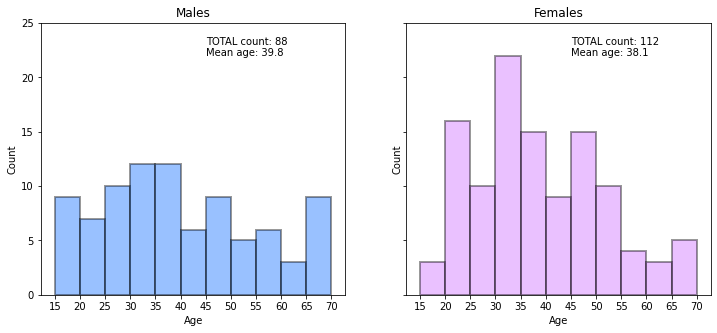

In [6]:
males_age = mall_data[mall_data['Gender']=='Male']['Age'] # subset with males age
females_age = mall_data[mall_data['Gender']=='Female']['Age'] # subset with females age

age_bins = range(15,75,5)

# males histogram
fig2, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5), sharey=True)
sns.distplot(males_age, bins=age_bins, kde=False, color='#0066ff', ax=ax1, hist_kws=dict(edgecolor="k", linewidth=2))
ax1.set_xticks(age_bins)
ax1.set_ylim(top=25)
ax1.set_title('Males')
ax1.set_ylabel('Count')
ax1.text(45,23, "TOTAL count: {}".format(males_age.count()))
ax1.text(45,22, "Mean age: {:.1f}".format(males_age.mean()))

# females histogram
sns.distplot(females_age, bins=age_bins, kde=False, color='#cc66ff', ax=ax2, hist_kws=dict(edgecolor="k", linewidth=2))
ax2.set_xticks(age_bins)
ax2.set_title('Females')
ax2.set_ylabel('Count')
ax2.text(45,23, "TOTAL count: {}".format(females_age.count()))
ax2.text(45,22, "Mean age: {:.1f}".format(females_age.mean()))

plt.show()

- 남성 고객의 평균 나이가 여성 고객보다 조금 많다.
- 남성 고객의 나이 분포는 여성 고객보다 좀 더 균일(uniform)하다.
- 남성 고객과 여성 고객의 비율을 비교해보면 여성 고객이 좀 더 많은 것을 확인할 수 있다.

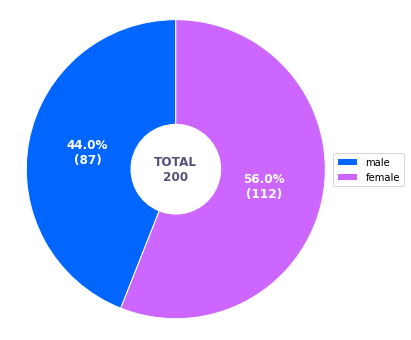

In [7]:
def labeler(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}%\n({:d})".format(pct, absolute)

sizes = [males_age.count(),females_age.count()] # wedge sizes

fig0, ax1 = plt.subplots(figsize=(6,6))
wedges, texts, autotexts = ax1.pie(sizes,
                                   autopct=lambda pct: labeler(pct, sizes),
                                   radius=1,
                                   colors=['#0066ff','#cc66ff'],
                                   startangle=90,
                                   textprops=dict(color="w"),
                                   wedgeprops=dict(width=0.7, edgecolor='w'))

ax1.legend(wedges, ['male','female'],
           loc='center right',
           bbox_to_anchor=(0.7, 0, 0.5, 1))

plt.text(0,0, 'TOTAL\n{}'.format(mall_data['Age'].count()),
         weight='bold', size=12, color='#52527a',
         ha='center', va='center')

plt.setp(autotexts, size=12, weight='bold')
ax1.axis('equal')  # Equal aspect ratio
plt.show()

> **Annual Income | Gender**

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


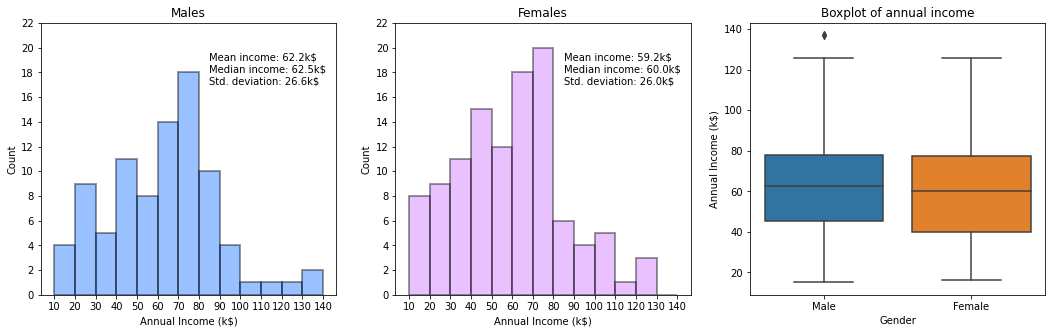

In [8]:
males_income = mall_data[mall_data['Gender']=='Male']['Annual Income (k$)'] # subset with males income
females_income = mall_data[mall_data['Gender']=='Female']['Annual Income (k$)'] # subset with females income

my_bins = range(10,150,10)

# males histogram
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18,5))
sns.distplot(males_income, bins=my_bins, kde=False, color='#0066ff', ax=ax1, hist_kws=dict(edgecolor="k", linewidth=2))
ax1.set_xticks(my_bins)
ax1.set_yticks(range(0,24,2))
ax1.set_ylim(0,22)
ax1.set_title('Males')
ax1.set_ylabel('Count')
ax1.text(85,19, "Mean income: {:.1f}k$".format(males_income.mean()))
ax1.text(85,18, "Median income: {:.1f}k$".format(males_income.median()))
ax1.text(85,17, "Std. deviation: {:.1f}k$".format(males_income.std()))

# females histogram
sns.distplot(females_income, bins=my_bins, kde=False, color='#cc66ff', ax=ax2, hist_kws=dict(edgecolor="k", linewidth=2))
ax2.set_xticks(my_bins)
ax2.set_yticks(range(0,24,2))
ax2.set_ylim(0,22)
ax2.set_title('Females')
ax2.set_ylabel('Count')
ax2.text(85,19, "Mean income: {:.1f}k$".format(females_income.mean()))
ax2.text(85,18, "Median income: {:.1f}k$".format(females_income.median()))
ax2.text(85,17, "Std. deviation: {:.1f}k$".format(females_income.std()))

# boxplot
sns.boxplot(x='Gender', y='Annual Income (k$)', data=mall_data, ax=ax3)
ax3.set_title('Boxplot of annual income')
plt.show()

- 남성 고객의 평균 수입과 중앙값이 여성 고객보다 높다.
- 표준 편차는 두 성별 모두 비슷하다.
- 남성 고객에는 하나의 이상치가 관측된다.

> **Spending Score | Gender**

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


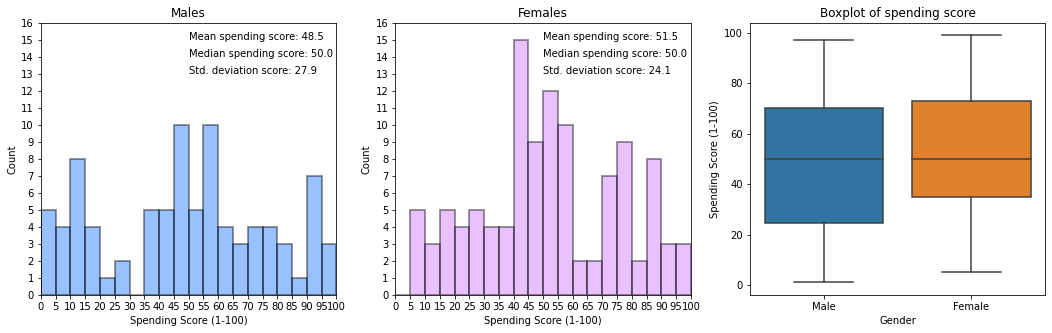

In [9]:
males_spending = mall_data[mall_data['Gender']=='Male']['Spending Score (1-100)'] # subset with males age
females_spending = mall_data[mall_data['Gender']=='Female']['Spending Score (1-100)'] # subset with females age

spending_bins = range(0,105,5)

# males histogram
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18,5))
sns.distplot(males_spending, bins=spending_bins, kde=False, color='#0066ff', ax=ax1, hist_kws=dict(edgecolor="k", linewidth=2))
ax1.set_xticks(spending_bins)
ax1.set_xlim(0,100)
ax1.set_yticks(range(0,17,1))
ax1.set_ylim(0,16)
ax1.set_title('Males')
ax1.set_ylabel('Count')
ax1.text(50,15, "Mean spending score: {:.1f}".format(males_spending.mean()))
ax1.text(50,14, "Median spending score: {:.1f}".format(males_spending.median()))
ax1.text(50,13, "Std. deviation score: {:.1f}".format(males_spending.std()))

# females histogram
sns.distplot(females_spending, bins=spending_bins, kde=False, color='#cc66ff', ax=ax2, hist_kws=dict(edgecolor="k", linewidth=2))
ax2.set_xticks(spending_bins)
ax2.set_xlim(0,100)
ax2.set_yticks(range(0,17,1))
ax2.set_ylim(0,16)
ax2.set_title('Females')
ax2.set_ylabel('Count')
ax2.text(50,15, "Mean spending score: {:.1f}".format(females_spending.mean()))
ax2.text(50,14, "Median spending score: {:.1f}".format(females_spending.median()))
ax2.text(50,13, "Std. deviation score: {:.1f}".format(females_spending.std()))

# boxplot
sns.boxplot(x='Gender', y='Spending Score (1-100)', data=mall_data, ax=ax3)
ax3.set_title('Boxplot of spending score')
plt.show()

plt.show()

- 평균 소비 점수는 여성 고객이 남성 고객보다 높다.

> **Mean Income | Age, Gender**

In [10]:
medians_by_age_group = mall_data.groupby(["Gender",pd.cut(mall_data['Age'], age_bins)]).median()
medians_by_age_group.index = medians_by_age_group.index.set_names(['Gender', 'Age_group'])
medians_by_age_group.reset_index(inplace=True)

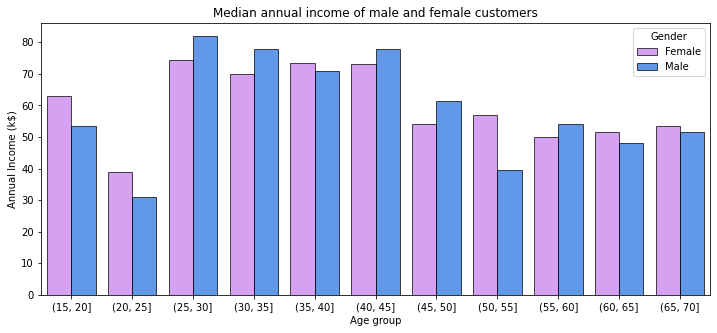

In [12]:
fig, ax = plt.subplots(figsize=(12,5))
sns.barplot(x='Age_group', y='Annual Income (k$)', hue='Gender', data=medians_by_age_group,
            palette=['#cc66ff','#0066ff'],
            alpha=0.7,edgecolor='k',
            ax=ax)
ax.set_title('Median annual income of male and female customers')
ax.set_xlabel('Age group')
plt.show()

- 이 그래프는 대부분의 부유한 고객이 25~45세라는 것을 보여준다.
- 25 ~ 30과 50 ~ 55 나이대에서,남성 고객과 여성 고객이 유의미한 차이를 보인다.

#### | **3.2 Correlations**
___
- Numerical 변수 간의 상관 관계에 대해 알아보자.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


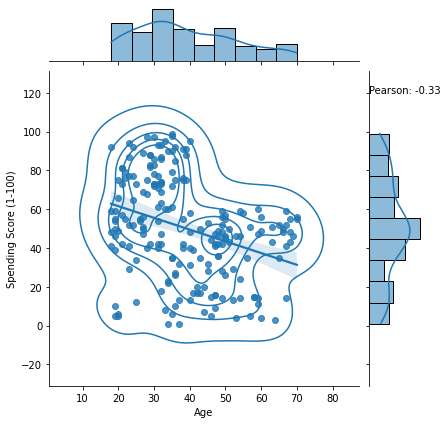

In [13]:
from scipy.stats import pearsonr

# calculating Pearson's correlation
corr, _ = pearsonr(mall_data['Age'], mall_data['Spending Score (1-100)'])

jp = (sns.jointplot('Age', 'Spending Score (1-100)', data=mall_data,
                    kind='reg')).plot_joint(sns.kdeplot, zorder=0, n_levels=6)

plt.text(0,120, 'Pearson: {:.2f}'.format(corr))
plt.show()

> **Age & Annual Income**

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


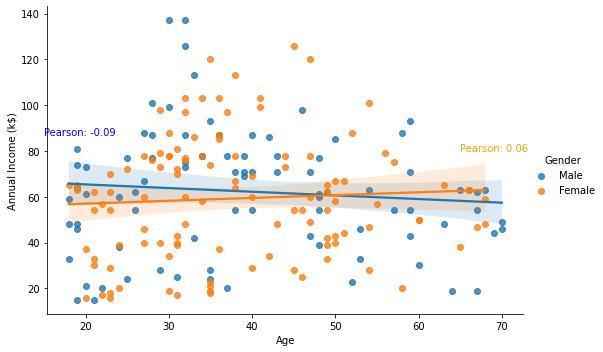

In [14]:
# calculating Pearson's correlations
corr1, _ = pearsonr(males_age.values, males_income.values)
corr2, _ = pearsonr(females_age.values, females_income.values)

sns.lmplot('Age', 'Annual Income (k$)', data=mall_data, hue='Gender', aspect=1.5)

plt.text(15,87, 'Pearson: {:.2f}'.format(corr1), color='blue')
plt.text(65,80, 'Pearson: {:.2f}'.format(corr2), color='orange')

plt.show()

- `Age`와 `Annual Income`는 두 성별 모두 상관성이 거의 없다.

> **Age & Spending Score**

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


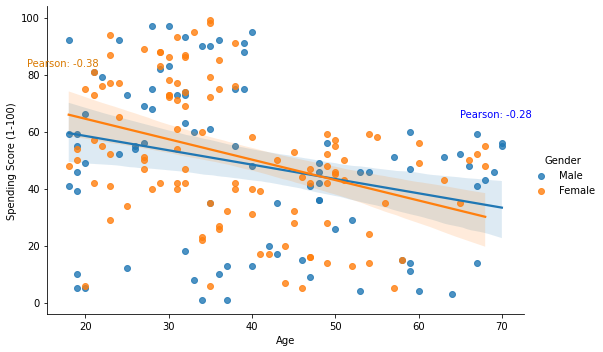

In [15]:
# calculating Pearson's correlations
corr1, _ = pearsonr(males_age.values, males_spending.values)
corr2, _ = pearsonr(females_age.values, females_spending.values)

sns.lmplot('Age', 'Spending Score (1-100)', data=mall_data, hue='Gender',
          aspect=1.5)

plt.text(65,65, 'Pearson: {:.2f}'.format(corr1), color='blue')
plt.text(13,83, 'Pearson: {:.2f}'.format(corr2), color='#d97900')

plt.show()

- `Age`와 `Spending Score` 사이에는 두 성별 집단 모두 약한 상관 관계가 존재한다.


> **Annual Income & Spending Score**

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


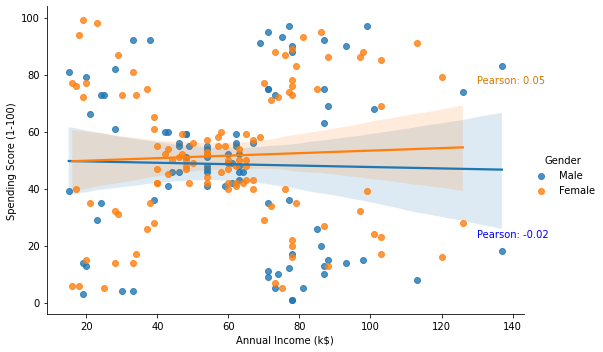

In [16]:
# calculating Pearson's correlations
corr1, _ = pearsonr(males_income.values, males_spending.values)
corr2, _ = pearsonr(females_income.values, females_spending.values)

sns.lmplot('Annual Income (k$)', 'Spending Score (1-100)', data=mall_data, hue='Gender',
          aspect=1.5)

plt.text(130,23, 'Pearson: {:.2f}'.format(corr1), color='blue')
plt.text(130,77, 'Pearson: {:.2f}'.format(corr2), color='#d97900')

plt.show()

- `Annual Income`와 `Spending Score` 사이에는 두 성별 집단 모두 상관성이 거의 없다.

### **4. Clustering**

#### | **4.1 K-Means**
___

##### **4.1.1 Description**
- K-Means 알고리즘
  1. seed point들을 이용하여 데이터를 초기 그룹으로 나눈다. seed point에 가장 가까운 데이터들부터 군집을 형성한다. 
  2. 해당 군집의 central point와 데이터 사이의 거리를 구하고, 가까운 군집에 데이터들을 할당한다.
  3. 새롭게 형성된 군집의 central point를 계산한다. 그리고 2번부터 다시 반복한다.
- K-Means를 사용하기 위해서는 군집 개수를 지정해주어야 한다.

##### **4.1.2 Use case - customers segmentation**

In [17]:
# import KMeans
from sklearn.cluster import KMeans 

- 해당 실습에서는 `gender`를 사용하지 않을 예정이기 때문에, 수치형 변수만 추출한 데이터셋을 생성한다.

In [18]:
X_numerics = mall_data[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']] # subset with numeric variables only

- 적절한 군집 개수를 구하기 위해, elbow method를 이용하였다. 즉, 각 군집 개수 별로 이너셔 그래프를 그려 보았다.

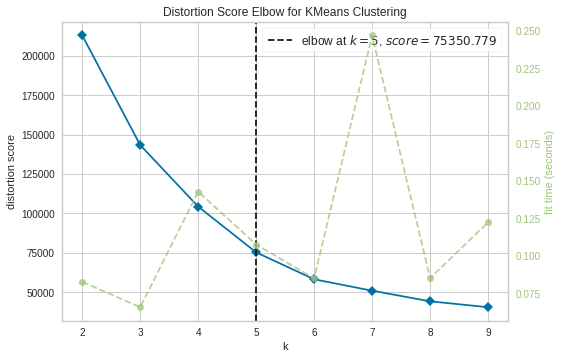

In [19]:
from yellowbrick.cluster import KElbowVisualizer

model = KMeans(random_state=1)
visualizer = KElbowVisualizer(model, k=(2,10))

visualizer.fit(X_numerics)
visualizer.show()
plt.show()

- 명확한 elbow가 보이지 않는다. 
- 이번에는 실루엣 점수를 이용하여, 최적의 군집 개수를 찾아보자.

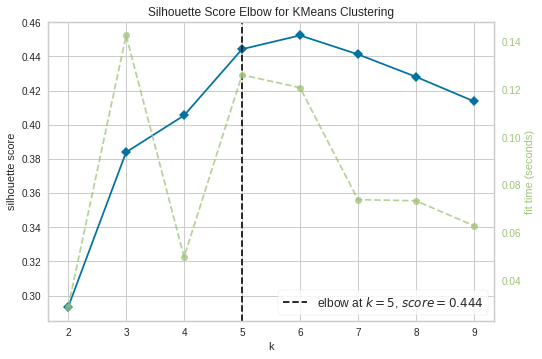

In [20]:
model = KMeans(random_state=1)
visualizer = KElbowVisualizer(model, k=(2,10), metric='silhouette')

visualizer.fit(X_numerics)
visualizer.show()
plt.show()

- 실루엣 계수 그래프를 그려본 결과, 5개 혹은 6개로 군집의 개수를 설정하는 것이 적절해 보인다.
- 각 군집 개수 별로 모델을 만들어 비교해보자.

> **The number of Clusters : 5**

In [21]:
KM_5_clusters = KMeans(n_clusters=5, init='k-means++').fit(X_numerics) # initialise and fit K-Means model

KM5_clustered = X_numerics.copy()
KM5_clustered.loc[:,'Cluster'] = KM_5_clusters.labels_ # append labels to points

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


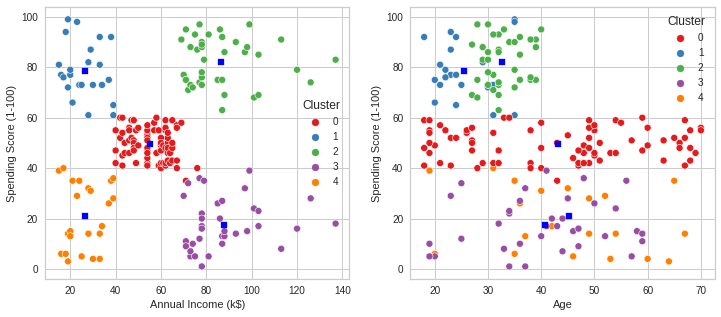

In [22]:
fig1, (axes) = plt.subplots(1,2,figsize=(12,5))


scat_1 = sns.scatterplot('Annual Income (k$)', 'Spending Score (1-100)', data=KM5_clustered,
                hue='Cluster', ax=axes[0], palette='Set1', legend='full')

sns.scatterplot('Age', 'Spending Score (1-100)', data=KM5_clustered,
                hue='Cluster', palette='Set1', ax=axes[1], legend='full')

axes[0].scatter(KM_5_clusters.cluster_centers_[:,1],KM_5_clusters.cluster_centers_[:,2], marker='s', s=40, c="blue")
axes[1].scatter(KM_5_clusters.cluster_centers_[:,0],KM_5_clusters.cluster_centers_[:,2], marker='s', s=40, c="blue")
plt.show()

- K-Means 알고리즘이 5개의 군집을 형성하였다. 이 군집들의 특징은 다음과 같다.
  + 연간 수익이 적지만 소비 점수가 높은 고객
  + 연간 수익이 중간 정도이고, 소비 점수도 중간 정도인 고객
  + 연간 수익이 높고, 소비 점수가 낮은 고객
  + 연간 수익이 높고, 소비 점수도 높은 고객
  + 연간 수익이 적고 소비 점수도 낮은 고객
- 각 군집에 속한 데이터의 개수들을 확인해보았다.

In [23]:
KM_clust_sizes = KM5_clustered.groupby('Cluster').size().to_frame()
KM_clust_sizes.columns = ["KM_size"]
KM_clust_sizes

,KM_size
Cluster,
0,79
1,23
2,39
3,36
4,23


In [29]:
import plotly as py
import plotly.graph_objs as go

def tracer(db, n, name):
    '''
    This function returns trace object for Plotly
    '''
    return go.Scatter3d(
        x = db[db['Cluster']==n]['Age'],
        y = db[db['Cluster']==n]['Spending Score (1-100)'],
        z = db[db['Cluster']==n]['Annual Income (k$)'],
        mode = 'markers',
        name = name,
        marker = dict(
            size = 5
        )
     )

trace0 = tracer(KM5_clustered, 0, 'Cluster 0')
trace1 = tracer(KM5_clustered, 1, 'Cluster 1')
trace2 = tracer(KM5_clustered, 2, 'Cluster 2')
trace3 = tracer(KM5_clustered, 3, 'Cluster 3')
trace4 = tracer(KM5_clustered, 4, 'Cluster 4')

data = [trace0, trace1, trace2, trace3, trace4]

layout = go.Layout(
    title = 'Clusters by K-Means',
    scene = dict(
            xaxis = dict(title = 'Age'),
            yaxis = dict(title = 'Spending Score'),
            zaxis = dict(title = 'Annual Income')
        )
)

fig = go.Figure(data=data, layout=layout)
py.offline.iplot(fig)

- 실루엣 그래프를 그려 군집이 잘 되었는지 확인해보았다.

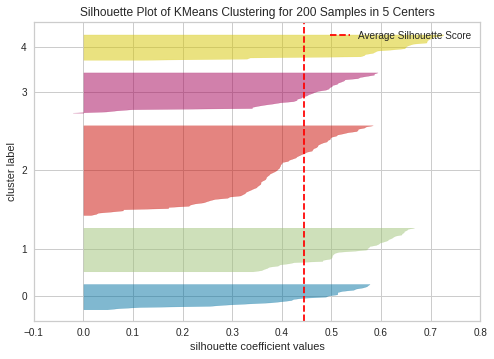

In [24]:
from yellowbrick.cluster import SilhouetteVisualizer
model = KMeans(n_clusters=5, random_state=0)
visualizer = SilhouetteVisualizer(model, colors='yellowbrick')
visualizer.fit(X_numerics)
visualizer.show()
plt.show()

> **The number of Clusters : 6**

In [25]:
KM_6_clusters = KMeans(n_clusters=6, init='k-means++').fit(X_numerics) # initialise and fit K-Means model

KM6_clustered = X_numerics.copy()
KM6_clustered.loc[:,'Cluster'] = KM_6_clusters.labels_ # append labels to points

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


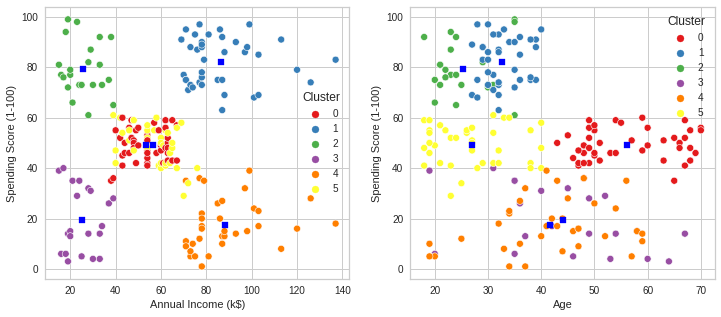

In [26]:
fig11, (axes) = plt.subplots(1,2,figsize=(12,5))

sns.scatterplot('Annual Income (k$)', 'Spending Score (1-100)', data=KM6_clustered,
                hue='Cluster', ax=axes[0], palette='Set1', legend='full')

sns.scatterplot('Age', 'Spending Score (1-100)', data=KM6_clustered,
                hue='Cluster', palette='Set1', ax=axes[1], legend='full')

# plotting centroids
axes[0].scatter(KM_6_clusters.cluster_centers_[:,1], KM_6_clusters.cluster_centers_[:,2], marker='s', s=40, c="blue")
axes[1].scatter(KM_6_clusters.cluster_centers_[:,0], KM_6_clusters.cluster_centers_[:,2], marker='s', s=40, c="blue")
plt.show()

- K-Means 알고리즘이 6개의 군집을 형성하였다. 이 군집들의 특징은 다음과 같다.
  + 나이가 많고, 연간 수익이 중간 정도이고, 소비 점수도 중간 정도인 고객
  + 연간 수익이 높고, 소비 점수가 낮은 고객
  + 나이가 어리고, 연간 수익이 중간 정도이고, 소비 점수도 중간 정도인 고객
  + 연간 수익이 높고, 소비 점수도 높은 고객
  + 연간 수익이 적고 소비 점수도 낮은 고객
  + 연간 수익이 적지만 소비 점수가 높은 고객
- 각 군집에 속한 데이터의 개수들을 확인해보았다.

In [27]:
KM6_clust_sizes = KM6_clustered.groupby('Cluster').size().to_frame()
KM6_clust_sizes.columns = ["KM_size"]
KM6_clust_sizes

,KM_size
Cluster,
0,45
1,39
2,22
3,21
4,35
5,38


In [30]:
# Plotly interactive 3D plot

trace0 = tracer(KM6_clustered, 0, 'Cluster 0')
trace1 = tracer(KM6_clustered, 1, 'Cluster 1')
trace2 = tracer(KM6_clustered, 2, 'Cluster 2')
trace3 = tracer(KM6_clustered, 3, 'Cluster 3')
trace4 = tracer(KM6_clustered, 4, 'Cluster 4')
trace5 = tracer(KM6_clustered, 5, 'Cluster 5')

data = [trace0, trace1, trace2, trace3, trace4, trace5]

layout = go.Layout(
    title = 'Clusters by K-Means',
    scene = dict(
            xaxis = dict(title = 'Age'),
            yaxis = dict(title = 'Spending Score'),
            zaxis = dict(title = 'Annual Income')
        )
)

fig = go.Figure(data=data, layout=layout)
py.offline.iplot(fig)

- 역시 실루엣 그래프를 그려 군집이 잘 되었는지 확인해보았다.

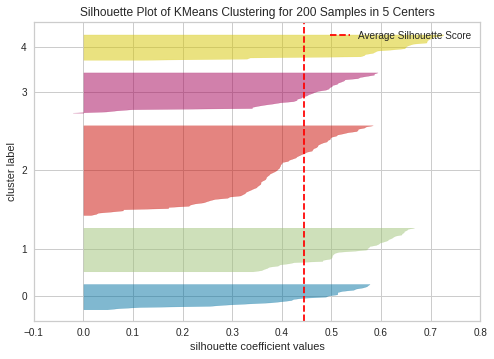

In [31]:
from yellowbrick.cluster import SilhouetteVisualizer
model = KMeans(n_clusters=5, random_state=0)
visualizer = SilhouetteVisualizer(model, colors='yellowbrick')
visualizer.fit(X_numerics)
visualizer.show()
plt.show()

#### | **4.2 DBSCAN**
___

##### **4.2.1 Description**
- DBSCAN은 밀도 기반의 군집 알고리즘으로, 2개의 하이퍼 파라미터를 가지고 있다.
  + $\epsilon$ : 반경
  + Minpoints : $\epsilon$ 반경에 포함될 데이터의 최소 개수를 의미한다.
- DBSCAN은 $\epsilon$과 Minpoints에 기반하여, 알아서  최적의 군집 개수를 찾을 수 있으며, 타원형의 데이터에서도 잘 작동한다.
- 하지만 계산이 오래 걸린다는 단점이 있으며 군집의 밀도가 다양하면 좋은 결과를 내지 못한다는 단점이 있다.




##### **4.2.2 Use case - customers segmentation**

In [32]:
# import DBSCAN
from sklearn.cluster import DBSCAN

- `eps`와 `min_samples` 값을 여러 개 준비하여, 각 파라미터 값 별 모델 성능을 비교해본다.

In [33]:
from itertools import product

eps_values = np.arange(8,12.75,0.25) # eps values to be investigated
min_samples = np.arange(3,10) # min_samples values to be investigated

DBSCAN_params = list(product(eps_values, min_samples))

In [34]:
from sklearn.metrics import silhouette_score

no_of_clusters = []
sil_score = []

for p in DBSCAN_params:
    DBS_clustering = DBSCAN(eps=p[0], min_samples=p[1]).fit(X_numerics)
    no_of_clusters.append(len(np.unique(DBS_clustering.labels_)))
    sil_score.append(silhouette_score(X_numerics, DBS_clustering.labels_))

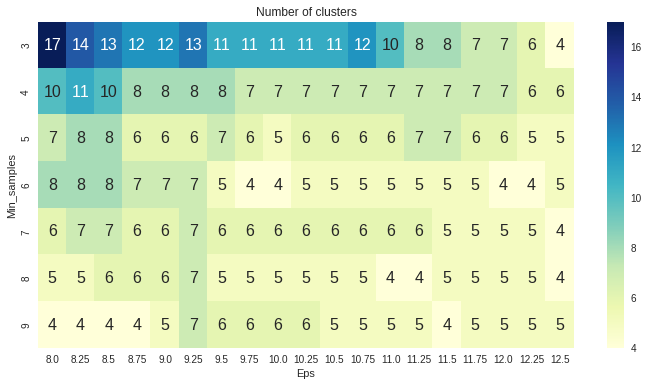

In [35]:
tmp = pd.DataFrame.from_records(DBSCAN_params, columns =['Eps', 'Min_samples'])   
tmp['No_of_clusters'] = no_of_clusters

pivot_1 = pd.pivot_table(tmp, values='No_of_clusters', index='Min_samples', columns='Eps')

fig, ax = plt.subplots(figsize=(12,6))
sns.heatmap(pivot_1, annot=True,annot_kws={"size": 16}, cmap="YlGnBu", ax=ax)
ax.set_title('Number of clusters')
plt.show()

- 대부분 4~7개로 군집을 형성하고 있다.
- 이번에는 각 파라미터별 실루엣 점수를 비교해보자.

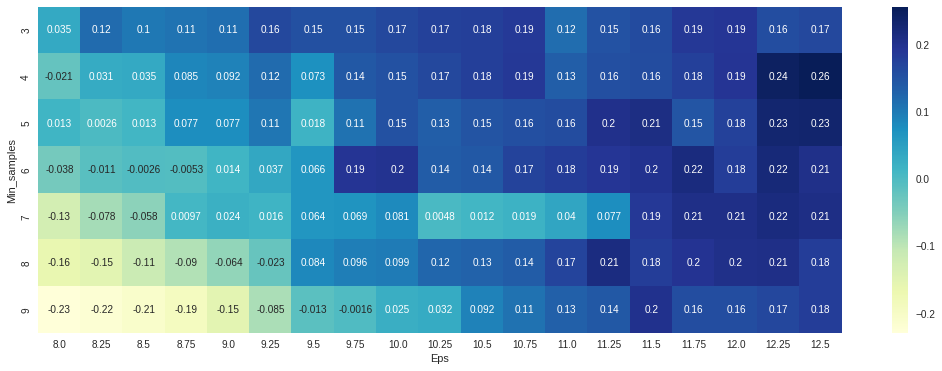

In [36]:
tmp = pd.DataFrame.from_records(DBSCAN_params, columns =['Eps', 'Min_samples'])   
tmp['Sil_score'] = sil_score

pivot_1 = pd.pivot_table(tmp, values='Sil_score', index='Min_samples', columns='Eps')

fig, ax = plt.subplots(figsize=(18,6))
sns.heatmap(pivot_1, annot=True, annot_kws={"size": 10}, cmap="YlGnBu", ax=ax)
plt.show()

- `eps` 값이 12.5이고 `min_samples`이 4개일 때, 실루엣 점수가 가장 좋다.

In [37]:
# 최적 파라미터로 모델 학습
DBS_clustering = DBSCAN(eps=12.5, min_samples=4).fit(X_numerics)

DBSCAN_clustered = X_numerics.copy()
DBSCAN_clustered.loc[:,'Cluster'] = DBS_clustering.labels_ # append labels to points

In [38]:
DBSCAN_clust_sizes = DBSCAN_clustered.groupby('Cluster').size().to_frame()
DBSCAN_clust_sizes.columns = ["DBSCAN_size"]
DBSCAN_clust_sizes

,DBSCAN_size
Cluster,
-1,18
0,112
1,8
2,34
3,24
4,4


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



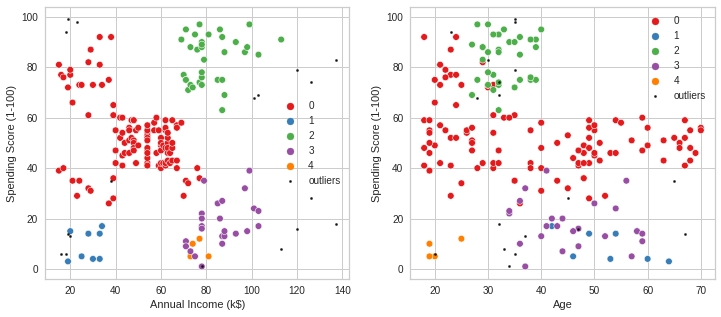

In [39]:
outliers = DBSCAN_clustered[DBSCAN_clustered['Cluster']==-1]

fig2, (axes) = plt.subplots(1,2,figsize=(12,5))


sns.scatterplot('Annual Income (k$)', 'Spending Score (1-100)',
                data=DBSCAN_clustered[DBSCAN_clustered['Cluster']!=-1],
                hue='Cluster', ax=axes[0], palette='Set1', legend='full', s=45)

sns.scatterplot('Age', 'Spending Score (1-100)',
                data=DBSCAN_clustered[DBSCAN_clustered['Cluster']!=-1],
                hue='Cluster', palette='Set1', ax=axes[1], legend='full', s=45)

axes[0].scatter(outliers['Annual Income (k$)'], outliers['Spending Score (1-100)'], s=5, label='outliers', c="k")
axes[1].scatter(outliers['Age'], outliers['Spending Score (1-100)'], s=5, label='outliers', c="k")
axes[0].legend()
axes[1].legend()

plt.setp(axes[0].get_legend().get_texts(), fontsize='10')
plt.setp(axes[1].get_legend().get_texts(), fontsize='10')

plt.show()

#### | **4.3 Affinity Propagation**
___

##### **4.3.1 Description**
- AP 알고리즘의 파라미터
  1. Preference : 사용할 exemplars의 개수를 결정한다.(음수값)
  2. Damping factor : message를 업데이트할 때 생기는 진동을 방지하는 파라미터.

##### **4.3.2 Use case - customers segmentation**

In [40]:
# import AP
from sklearn.cluster import AffinityPropagation

In [42]:
no_of_clusters = []
preferences = range(-20000,-5000,200) # arbitraty chosen range
af_sil_score = [] # silouette scores

for p in preferences:
    AF = AffinityPropagation(preference=p, max_iter=200).fit(X_numerics)
    no_of_clusters.append((len(np.unique(AF.labels_))))
    af_sil_score.append(silhouette_score(X_numerics, AF.labels_))
    
af_results = pd.DataFrame([preferences, no_of_clusters, af_sil_score], index=['preference','clusters', 'sil_score']).T
af_results.sort_values(by='sil_score', ascending=False).head() # display only 5 best scores

,preference,clusters,sil_score
41,-11800.0,6.0,0.451649
63,-7400.0,6.0,0.451440
26,-14800.0,6.0,0.451440
46,-10800.0,6.0,0.451440
14,-17200.0,6.0,0.451440


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



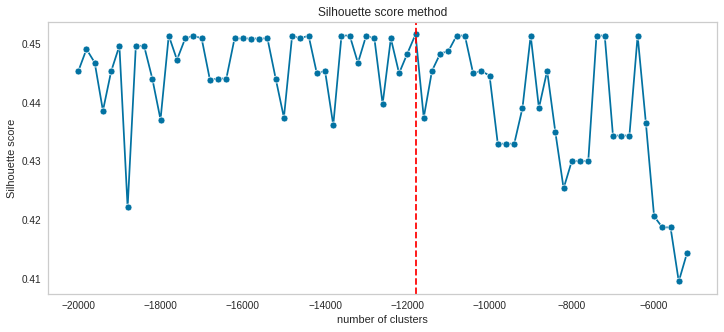

In [43]:
fig, ax = plt.subplots(figsize=(12,5))
ax = sns.lineplot(preferences, af_sil_score, marker='o', ax=ax)
ax.set_title("Silhouette score method")
ax.set_xlabel("number of clusters")
ax.set_ylabel("Silhouette score")
ax.axvline(-11800, ls="--", c="red")
plt.grid()
plt.show()

In [44]:
AF = AffinityPropagation(preference=-11800).fit(X_numerics)

In [45]:
AF_clustered = X_numerics.copy()
AF_clustered.loc[:,'Cluster'] = AF.labels_ # append labels to points

In [46]:
AF_clust_sizes = AF_clustered.groupby('Cluster').size().to_frame()
AF_clust_sizes.columns = ["AF_size"]
AF_clust_sizes

,AF_size
Cluster,
0,22
1,22
2,44
3,39
4,34
5,39


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



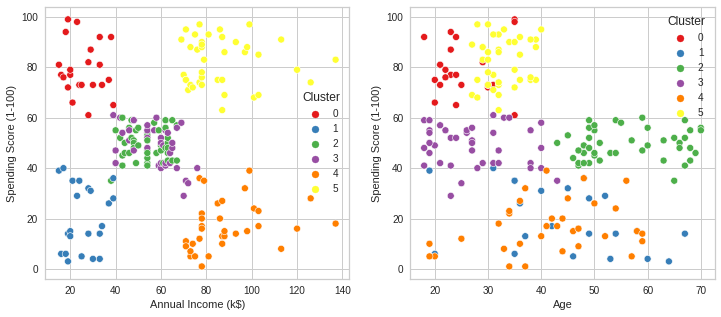

In [47]:
fig3, (ax_af) = plt.subplots(1,2,figsize=(12,5))


scat_1 = sns.scatterplot('Annual Income (k$)', 'Spending Score (1-100)', data=AF_clustered,
                hue='Cluster', ax=ax_af[0], palette='Set1', legend='full')

sns.scatterplot('Age', 'Spending Score (1-100)', data=AF_clustered,
                hue='Cluster', palette='Set1', ax=ax_af[1], legend='full')

plt.setp(ax_af[0].get_legend().get_texts(), fontsize='10')
plt.setp(ax_af[1].get_legend().get_texts(), fontsize='10')
plt.show()

### **5. Comparison and discussion**

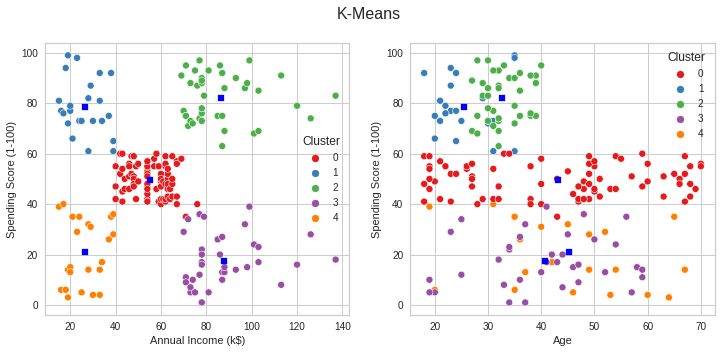

In [48]:
fig1.suptitle('K-Means', fontsize=16)
fig1

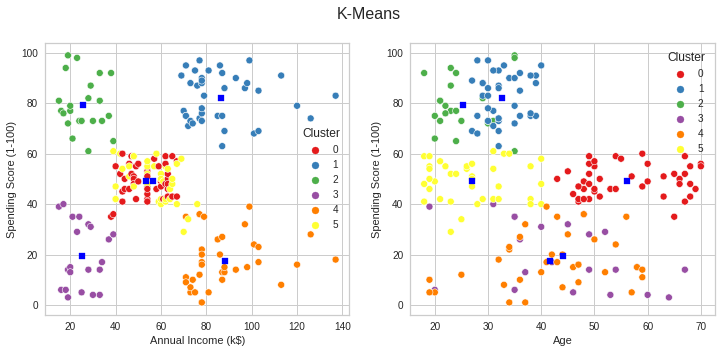

In [49]:
fig11.suptitle('K-Means', fontsize=16)
fig11

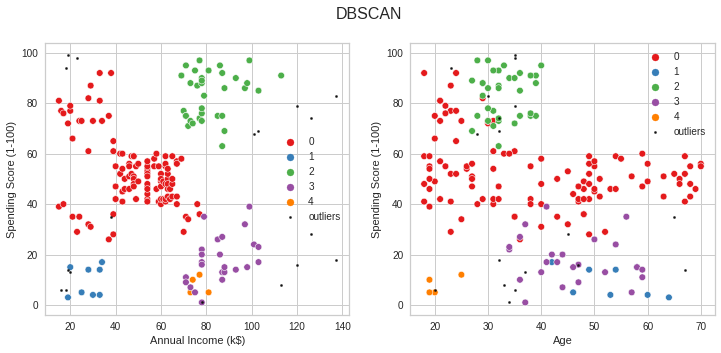

In [50]:
fig2.suptitle('DBSCAN', fontsize=16)
fig2

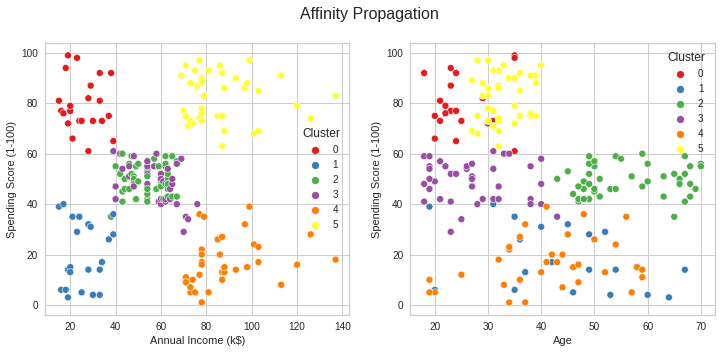

In [51]:
fig3.suptitle('Affinity Propagation', fontsize=16)
fig3

In [52]:
clusters = pd.concat([KM6_clust_sizes, DBSCAN_clust_sizes, AF_clust_sizes],axis=1, sort=False)
clusters

,KM_size,DBSCAN_size,AF_size
Cluster,,,
-1,NaN,18.0,NaN
0,45.0,112.0,22.0
1,39.0,8.0,22.0
2,22.0,34.0,44.0
3,21.0,24.0,39.0
4,35.0,4.0,34.0
5,38.0,NaN,39.0
